In [1]:
pip install numpy pandas scikit-learn tensorflow matplotlib seaborn jupyterlab torch torch-geometric rdkit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# === Core Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob
import gc
from tqdm import tqdm
import concurrent.futures

# === RDKit for Molecular Processing ===
from rdkit import Chem

# === PyTorch & PyTorch Geometric ===
import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool

# === TensorFlow / Keras ===
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D,
    BatchNormalization, Dropout, Dense, Concatenate, Add, LayerNormalization
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.losses import MeanSquaredError

# === Scikit-learn ===
from sklearn.model_selection import train_test_split


c:\Users\NongNam\Documents\AI_Builder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === Load data ===
df = pd.read_csv("Kd.csv")
df.head()

,SMILES,target_sequence,Kd
0,COc1cc2nc(cnc2cc1OCC#N)-c1ccc(CC(=O)Nc2cc(on2)...,MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSS...,8.301030
1,Cn1nc(C(=O)NC[C@@]2(O)CC[C@@H](CC2)S(C)(=O)=O)...,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,7.795880
2,Oc1ccc(/C=C/c2cc(O)cc(O)c2)cc1,MDDIYKAAVEQLTEEQKNEFKAAFDIFVLGAEDGCISTKELGKVMR...,3.614394
3,Cc1ccc(CNc2nc3c(N)ncnc3n2[C@@H]2O[C@H](CO)[C@@...,MSKGPAVGIDLGTTYSCVGVFQHGKVEIIANDQGNRTTPSYVAFTD...,6.530178
4,CC\C=C\CCOC(=O)c1cccnc1,MSALGVTVALLVWAAFLLLVSMWRQVHSSWNLPPGPFPLPIIGNLF...,5.886057


In [4]:
df.isna().sum()

SMILES             0
target_sequence    0
Kd                 0
dtype: int64

In [5]:
len(df)

55011

In [3]:
# Encode amino acid sequences
aa_list = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i + 1 for i, aa in enumerate(aa_list)}

def encode_protein(seq):
    return [aa_to_int.get(aa, 0) for aa in seq]

df['protein_encoded'] = df['target_sequence'].apply(encode_protein)

# Pad protein sequences
max_len_protein = 1000
X_protein = pad_sequences(df['protein_encoded'], maxlen=max_len_protein, padding='post')

# Store Kd values
y_kd = df['Kd'].values


In [4]:
def get_atom_features(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        int(atom.GetHybridization()),
        int(atom.GetIsAromatic())
    ]

In [5]:
def get_bond_features(bond):
    return [
        int(bond.GetBondTypeAsDouble()),   # Single=1.0, Double=2.0, etc.
        int(bond.GetIsConjugated()),
        int(bond.GetIsAromatic())
    ]

In [6]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    smiles = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(smiles)

    x = torch.tensor([get_atom_features(atom) for atom in mol.GetAtoms()], dtype=torch.float)

    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        bond_feat = get_bond_features(bond)
        edge_attr += [bond_feat, bond_feat]  # Add both directions

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Apply and filter out None values (only valid SMILES)
graph_data_list = []
valid_indices = []

for i, smiles in enumerate(df['SMILES']):
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graph_data_list.append(graph)
        valid_indices.append(i)

# Filter protein and Kd tensors to match valid molecules
X_protein = X_protein[valid_indices]
y_kd = y_kd[valid_indices]


[18:34:46] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:34:51] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:34:57] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:35:07] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:35:29] Explicit valence for atom # 22 N, 4, is greater than permitted
[18:35:41] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25
[18:35:50] Explicit valence for atom # 22 N, 4, is greater than permitted


In [7]:
print(graph_data_list[0])

Data(x=[39, 5], edge_index=[2, 86], edge_attr=[86, 3])


In [8]:
class GNNEncoder(nn.Module):
    def __init__(self, node_in=5, edge_in=3):
        super().__init__()
        self.edge_nn1 = nn.Sequential(
            nn.Linear(edge_in, 32),
            nn.ReLU(),
            nn.Linear(32, node_in * 64)
        )
        self.conv1 = NNConv(node_in, 64, self.edge_nn1, aggr='mean')

        self.edge_nn2 = nn.Sequential(
            nn.Linear(edge_in, 32),
            nn.ReLU(),
            nn.Linear(32, 64 * 128)
        )
        self.conv2 = NNConv(64, 128, self.edge_nn2, aggr='mean')

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = torch.relu(self.conv1(x, edge_index, edge_attr))
        x = torch.relu(self.conv2(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)
        return x

In [11]:
# --- Protein CNN Branch ---
protein_input = Input(shape=(max_len_protein,), name="protein_input")
x = Embedding(input_dim=len(aa_to_int) + 1, output_dim=64)(protein_input)
x1 = Conv1D(128, kernel_size=9, activation='relu', padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = Conv1D(256, kernel_size=9, activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)

x2 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
x2 = BatchNormalization()(x2)

# Skip connection via concatenation
merged_cnn = Concatenate()([x1, x2])
x_cnn = GlobalMaxPooling1D()(merged_cnn)
x_cnn = Dropout(0.4)(x_cnn)

# --- GNN Features Input ---
gnn_input = Input(shape=(128,), name="gnn_input")

# Optional layer norm or transformation layer
gnn_proj = Dense(128, activation='relu')(gnn_input)
gnn_proj = LayerNormalization()(gnn_proj)

# --- Merge branches ---
merged = Concatenate()([x_cnn, gnn_proj])

# Fully connected layers
x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.2)(x)

# Output layer
output = Dense(1, activation='linear')(x)

model = Model(inputs=[protein_input, gnn_input], outputs=output)
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ protein_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1000, 64)  │      1,344 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 128) │     73,856 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1000, 128) │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1000, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 128) │     41,088 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 256) │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1000, 384) │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 384)       │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 595,649 (2.27 MB)

 Trainable params: 594,113 (2.27 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [12]:
class EpochHistorySaver(Callback):
    def __init__(self, save_dir='GNN_MODEL'):
        super().__init__()
        self.save_dir = save_dir
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

        # Save history after each epoch
        filename = f'{self.save_dir}/history_epoch_{epoch+1:02d}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(self.history, f)


In [13]:
# Save the model at every epoch with the epoch number in the filename
checkpoint_cb = ModelCheckpoint(
    filepath='GNN_MODEL/model_epoch_{epoch:02d}.h5',
    save_freq='epoch',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

history_cb = EpochHistorySaver(save_dir='GNN_MODEL')

In [14]:
torch.cuda.empty_cache()
gc.collect()

14

In [ ]:
# Create a DataLoader for batching the graph data
batch_size = 32  # You can experiment with this size depending on your memory capacity

loader = DataLoader(graph_data_list, batch_size=batch_size, shuffle=False)

In [16]:
# Initialize the GNN encoder model
gnn_model = GNNEncoder()
gnn_model.eval()
gnn_model.cpu()  # Use CPU if GPU memory is limited

# List to store the GNN features
gnn_features_list = []

# Iterate over the DataLoader with tqdm for progress tracking
with torch.no_grad():
    for batch in tqdm(loader, desc="Extracting GNN Features"):
        gnn_features = gnn_model(batch)  # Forward pass through the GNN
        gnn_features_list.append(gnn_features.cpu().numpy())  # Store the features

# Concatenate all the features
gnn_features = np.concatenate(gnn_features_list, axis=0)

Extracting GNN Features: 100%|██████████| 1719/1719 [03:39<00:00,  7.83it/s]


In [17]:
# from tensorflow.keras.models import load_model
# model = load_model('GNN_MODEL/model_epoch_52.h5', compile=False)

In [18]:
# model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

In [19]:
# Train the combined model
history = model.fit(
    [X_protein, gnn_features],
    y_kd,
    epochs=100,
    batch_size=64,
    validation_split=0.18,
    callbacks=[checkpoint_cb, history_cb]
)

Epoch 1/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.8435 - mae: 1.9776
Epoch 1: saving model to GNN_MODEL/model_epoch_01.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1452s 2s/step - loss: 6.8398 - mae: 1.9770 - val_loss: 7.8804 - val_mae: 2.3939
Epoch 2/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.6622 - mae: 1.2631
Epoch 2: saving model to GNN_MODEL/model_epoch_02.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1391s 2s/step - loss: 2.6620 - mae: 1.2631 - val_loss: 5.1337 - val_mae: 1.9252
Epoch 3/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.2719 - mae: 1.1483
Epoch 3: saving model to GNN_MODEL/model_epoch_03.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1464s 2s/step - loss: 2.2718 - mae: 1.1482 - val_loss: 3.0808 - val_mae: 1.3575
Epoch 4/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.1302 - mae: 1.1114
Epoch 4: saving model to GNN_MODEL/model_epoch_04.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1397s 2s/step - loss: 2.1302 - mae: 1.1114 - val_loss: 2.8568 - val_mae: 1.2940
Epoch 5/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.0259 - mae: 1.0764
Epoch 5: saving model to GNN_MODEL/model_epoch_05.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1496s 2s/step - loss: 2.0259 - mae: 1.0764 - val_loss: 3.7630 - val_mae: 1.5870
Epoch 6/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.9501 - mae: 1.0527
Epoch 6: saving model to GNN_MODEL/model_epoch_06.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1380s 2s/step - loss: 1.9501 - mae: 1.0527 - val_loss: 2.4473 - val_mae: 1.1591
Epoch 7/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.9044 - mae: 1.0400
Epoch 7: saving model to GNN_MODEL/model_epoch_07.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1323s 2s/step - loss: 1.9043 - mae: 1.0400 - val_loss: 1.9143 - val_mae: 0.9792
Epoch 8/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.8318 - mae: 1.0193
Epoch 8: saving model to GNN_MODEL/model_epoch_08.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1399s 2s/step - loss: 1.8318 - mae: 1.0193 - val_loss: 1.6358 - val_mae: 0.9298
Epoch 9/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.8184 - mae: 1.0144
Epoch 9: saving model to GNN_MODEL/model_epoch_09.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1301s 2s/step - loss: 1.8184 - mae: 1.0144 - val_loss: 1.8691 - val_mae: 0.9547
Epoch 10/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.7848 - mae: 1.0015
Epoch 10: saving model to GNN_MODEL/model_epoch_10.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1089s 2s/step - loss: 1.7848 - mae: 1.0015 - val_loss: 1.6816 - val_mae: 0.9093
Epoch 11/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.7377 - mae: 0.9820
Epoch 11: saving model to GNN_MODEL/model_epoch_11.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1090s 2s/step - loss: 1.7377 - mae: 0.9820 - val_loss: 2.0630 - val_mae: 1.0265
Epoch 12/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.7101 - mae: 0.9789
Epoch 12: saving model to GNN_MODEL/model_epoch_12.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1092s 2s/step - loss: 1.7101 - mae: 0.9789 - val_loss: 1.5950 - val_mae: 0.9133
Epoch 13/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6821 - mae: 0.9730
Epoch 13: saving model to GNN_MODEL/model_epoch_13.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - loss: 1.6821 - mae: 0.9730 - val_loss: 1.9561 - val_mae: 0.9790
Epoch 14/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6622 - mae: 0.9607
Epoch 14: saving model to GNN_MODEL/model_epoch_14.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1204s 2s/step - loss: 1.6622 - mae: 0.9607 - val_loss: 1.5325 - val_mae: 0.8887
Epoch 15/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6118 - mae: 0.9483
Epoch 15: saving model to GNN_MODEL/model_epoch_15.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1197s 2s/step - loss: 1.6118 - mae: 0.9483 - val_loss: 1.9015 - val_mae: 0.9630
Epoch 16/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6208 - mae: 0.9471
Epoch 16: saving model to GNN_MODEL/model_epoch_16.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1178s 2s/step - loss: 1.6208 - mae: 0.9471 - val_loss: 1.4490 - val_mae: 0.8691
Epoch 17/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5451 - mae: 0.9264
Epoch 17: saving model to GNN_MODEL/model_epoch_17.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1194s 2s/step - loss: 1.5452 - mae: 0.9264 - val_loss: 1.5361 - val_mae: 0.8711
Epoch 18/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5693 - mae: 0.9298
Epoch 18: saving model to GNN_MODEL/model_epoch_18.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1209s 2s/step - loss: 1.5692 - mae: 0.9298 - val_loss: 1.4468 - val_mae: 0.9026
Epoch 19/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5274 - mae: 0.9198
Epoch 19: saving model to GNN_MODEL/model_epoch_19.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1181s 2s/step - loss: 1.5274 - mae: 0.9198 - val_loss: 1.4627 - val_mae: 0.8873
Epoch 20/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5618 - mae: 0.9294
Epoch 20: saving model to GNN_MODEL/model_epoch_20.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1204s 2s/step - loss: 1.5618 - mae: 0.9294 - val_loss: 1.5122 - val_mae: 0.8550
Epoch 21/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5053 - mae: 0.9076
Epoch 21: saving model to GNN_MODEL/model_epoch_21.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1202s 2s/step - loss: 1.5053 - mae: 0.9076 - val_loss: 1.5176 - val_mae: 0.8547
Epoch 22/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5375 - mae: 0.9210
Epoch 22: saving model to GNN_MODEL/model_epoch_22.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1171s 2s/step - loss: 1.5375 - mae: 0.9210 - val_loss: 1.4412 - val_mae: 0.8967
Epoch 23/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5035 - mae: 0.9118
Epoch 23: saving model to GNN_MODEL/model_epoch_23.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1161s 2s/step - loss: 1.5035 - mae: 0.9118 - val_loss: 1.4414 - val_mae: 0.8763
Epoch 24/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.4695 - mae: 0.8983
Epoch 24: saving model to GNN_MODEL/model_epoch_24.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1199s 2s/step - loss: 1.4695 - mae: 0.8983 - val_loss: 1.4571 - val_mae: 0.8427
Epoch 25/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.4698 - mae: 0.8976
Epoch 25: saving model to GNN_MODEL/model_epoch_25.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step - loss: 1.4698 - mae: 0.8976 - val_loss: 1.4484 - val_mae: 0.8819
Epoch 26/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.4521 - mae: 0.8936
Epoch 26: saving model to GNN_MODEL/model_epoch_26.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1241s 2s/step - loss: 1.4521 - mae: 0.8936 - val_loss: 1.4235 - val_mae: 0.8743
Epoch 27/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.4636 - mae: 0.8928
Epoch 27: saving model to GNN_MODEL/model_epoch_27.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1221s 2s/step - loss: 1.4636 - mae: 0.8928 - val_loss: 1.4360 - val_mae: 0.8671
Epoch 28/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.4384 - mae: 0.8884
Epoch 28: saving model to GNN_MODEL/model_epoch_28.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1231s 2s/step - loss: 1.4384 - mae: 0.8884 - val_loss: 1.3963 - val_mae: 0.8739
Epoch 29/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3997 - mae: 0.8715
Epoch 29: saving model to GNN_MODEL/model_epoch_29.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1218s 2s/step - loss: 1.3997 - mae: 0.8715 - val_loss: 1.4468 - val_mae: 0.8385
Epoch 30/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.4174 - mae: 0.8803
Epoch 30: saving model to GNN_MODEL/model_epoch_30.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1215s 2s/step - loss: 1.4174 - mae: 0.8803 - val_loss: 1.4581 - val_mae: 0.9247
Epoch 31/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.4073 - mae: 0.8795
Epoch 31: saving model to GNN_MODEL/model_epoch_31.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1250s 2s/step - loss: 1.4074 - mae: 0.8795 - val_loss: 1.3905 - val_mae: 0.8694
Epoch 32/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.4192 - mae: 0.8832
Epoch 32: saving model to GNN_MODEL/model_epoch_32.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1191s 2s/step - loss: 1.4191 - mae: 0.8832 - val_loss: 1.4173 - val_mae: 0.8945
Epoch 33/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.4267 - mae: 0.8784
Epoch 33: saving model to GNN_MODEL/model_epoch_33.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - loss: 1.4267 - mae: 0.8783 - val_loss: 1.4137 - val_mae: 0.8466
Epoch 34/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3915 - mae: 0.8687
Epoch 34: saving model to GNN_MODEL/model_epoch_34.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1241s 2s/step - loss: 1.3915 - mae: 0.8687 - val_loss: 1.4088 - val_mae: 0.8422
Epoch 35/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3639 - mae: 0.8608
Epoch 35: saving model to GNN_MODEL/model_epoch_35.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1233s 2s/step - loss: 1.3640 - mae: 0.8608 - val_loss: 1.3726 - val_mae: 0.8247
Epoch 36/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3604 - mae: 0.8550
Epoch 36: saving model to GNN_MODEL/model_epoch_36.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1238s 2s/step - loss: 1.3604 - mae: 0.8550 - val_loss: 1.4409 - val_mae: 0.8397
Epoch 37/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3659 - mae: 0.8593
Epoch 37: saving model to GNN_MODEL/model_epoch_37.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1204s 2s/step - loss: 1.3659 - mae: 0.8593 - val_loss: 1.3793 - val_mae: 0.8673
Epoch 38/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3595 - mae: 0.8580
Epoch 38: saving model to GNN_MODEL/model_epoch_38.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1209s 2s/step - loss: 1.3595 - mae: 0.8580 - val_loss: 1.4397 - val_mae: 0.9195
Epoch 39/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3651 - mae: 0.8621
Epoch 39: saving model to GNN_MODEL/model_epoch_39.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1227s 2s/step - loss: 1.3651 - mae: 0.8621 - val_loss: 1.4342 - val_mae: 0.8471
Epoch 40/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3498 - mae: 0.8530
Epoch 40: saving model to GNN_MODEL/model_epoch_40.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1236s 2s/step - loss: 1.3497 - mae: 0.8530 - val_loss: 1.3674 - val_mae: 0.8142
Epoch 41/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3366 - mae: 0.8448
Epoch 41: saving model to GNN_MODEL/model_epoch_41.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1208s 2s/step - loss: 1.3367 - mae: 0.8448 - val_loss: 1.5239 - val_mae: 0.8659
Epoch 42/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3776 - mae: 0.8658
Epoch 42: saving model to GNN_MODEL/model_epoch_42.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1226s 2s/step - loss: 1.3776 - mae: 0.8658 - val_loss: 1.3832 - val_mae: 0.8265
Epoch 43/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3094 - mae: 0.8351
Epoch 43: saving model to GNN_MODEL/model_epoch_43.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1248s 2s/step - loss: 1.3094 - mae: 0.8351 - val_loss: 1.3646 - val_mae: 0.8354
Epoch 44/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3051 - mae: 0.8330
Epoch 44: saving model to GNN_MODEL/model_epoch_44.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1247s 2s/step - loss: 1.3052 - mae: 0.8330 - val_loss: 1.3430 - val_mae: 0.8141
Epoch 45/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3062 - mae: 0.8315
Epoch 45: saving model to GNN_MODEL/model_epoch_45.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1215s 2s/step - loss: 1.3063 - mae: 0.8315 - val_loss: 1.3568 - val_mae: 0.8551
Epoch 46/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3174 - mae: 0.8392
Epoch 46: saving model to GNN_MODEL/model_epoch_46.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1243s 2s/step - loss: 1.3174 - mae: 0.8392 - val_loss: 1.3635 - val_mae: 0.8507
Epoch 47/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3056 - mae: 0.8368
Epoch 47: saving model to GNN_MODEL/model_epoch_47.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1259s 2s/step - loss: 1.3057 - mae: 0.8368 - val_loss: 1.3617 - val_mae: 0.8170
Epoch 48/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2959 - mae: 0.8289
Epoch 48: saving model to GNN_MODEL/model_epoch_48.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1281s 2s/step - loss: 1.2959 - mae: 0.8289 - val_loss: 1.3269 - val_mae: 0.8061
Epoch 49/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2901 - mae: 0.8264
Epoch 49: saving model to GNN_MODEL/model_epoch_49.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1293s 2s/step - loss: 1.2902 - mae: 0.8264 - val_loss: 1.3749 - val_mae: 0.8793
Epoch 50/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2784 - mae: 0.8225
Epoch 50: saving model to GNN_MODEL/model_epoch_50.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1296s 2s/step - loss: 1.2784 - mae: 0.8225 - val_loss: 1.3369 - val_mae: 0.8143
Epoch 51/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2837 - mae: 0.8201
Epoch 51: saving model to GNN_MODEL/model_epoch_51.h5


705/705 ━━━━━━━━━━━━━━━━━━━━ 1270s 2s/step - loss: 1.2837 - mae: 0.8201 - val_loss: 1.3217 - val_mae: 0.8112
Epoch 52/100
276/705 ━━━━━━━━━━━━━━━━━━━━ 12:34 2s/step - loss: 1.3349 - mae: 0.8418

KeyboardInterrupt: 

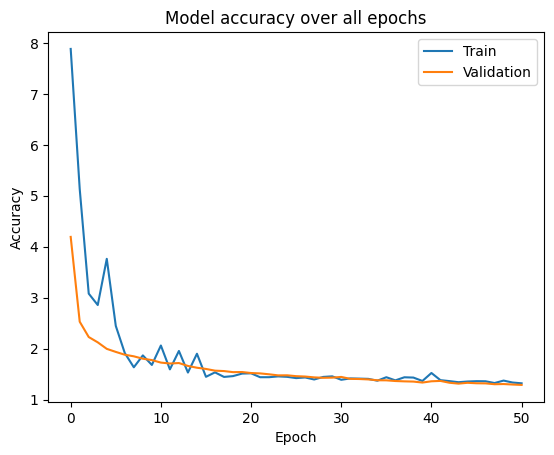

In [23]:
# Load all history files
history_files = sorted(glob.glob('GNN_MODEL/history_epoch_*.pkl'))

full_history = {}
for file in history_files:
    with open(file, 'rb') as f:
        epoch_history = pickle.load(f)
    for key, values in epoch_history.items():
        full_history.setdefault(key, []).extend(values[len(full_history.get(key, [])):])

# Plot


plt.plot(full_history['val_loss'])
plt.plot(full_history['loss'])
plt.title('Model accuracy over all epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()
